# first model

In [1]:
# Reading the uploaded FASTA file and modifying the headers to only retain the second string

input_file_path = 'data/fungi_ITS_sorted90.fasta'
output_file_path = 'data/fungi_ITS_cleaned.fasta'

# Open the input file and create the output file
with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            # Splitting the line and keeping only the second string
            header_parts = line.strip().split()
            if len(header_parts) > 1:
                modified_header = '>' + header_parts[1] + '\n'
                outfile.write(modified_header)
            else:
                outfile.write(line)
        else:
            outfile.write(line)

output_file_path


'data/fungi_ITS_cleaned.fasta'

# vectorization

In [2]:
import itertools

def generate_all_kmers(k):
    return [''.join(p) for p in itertools.product('ACGT', repeat=k)]

def kmer_vector(sequence, k):
    # gen all possible k-mers comb
    all_kmers = generate_all_kmers(k)
    vector = [0] * len(all_kmers)
    kmer_to_index = {kmer: idx for idx, kmer in enumerate(all_kmers)}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer in kmer_to_index:
            vector[kmer_to_index[kmer]] += 1
    return vector

input_file_path = 'data/fungi_ITS_cleaned.fasta'
output_file_path = 'data/fungi_ITS_kmer_vector.txt'

############################# k
k = 5


with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    current_sequence = ""
    current_header = ""
    
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k)
                vector_str = ' '.join(map(str, vector))
                outfile.write(f"{current_header}\t{vector_str}\n")
            current_header = line.strip()
            current_sequence = ""
        else:
            current_sequence += line.strip()
    
    if current_sequence:
        vector = kmer_vector(current_sequence, k)
        vector_str = ' '.join(map(str, vector))
        outfile.write(f"{current_header}\t{vector_str}\n")

output_file_path


'data/fungi_ITS_kmer_vector.txt'

In [3]:

from collections import defaultdict


input_file = 'data/fungi_ITS_kmer_vector.txt'
output_file = 'data/fungi_ITS_kmer_vector_filtered.txt'

genera_count = defaultdict(int)
with open(input_file, 'r') as f:
    for line in f:
        if line.startswith('>'):
            genus = line.split()[0][1:]
            genera_count[genus] += 1

# Filtering the sequences and saving to a new file
with open(input_file, 'r') as f, open(output_file, 'w') as out:
    write_line = False
    for line in f:
        if line.startswith('>'):
            genus = line.split()[0][1:]
            write_line = genera_count[genus] >= 10
        if write_line:
            out.write(line)

print("Filtering complete. The results are saved in 'fungi_ITS_kmer_vector_filtered.txt'.")


Filtering complete. The results are saved in 'fungi_ITS_kmer_vector_filtered.txt'.


In [4]:
# File paths
input_file_path = 'data/fungi_ITS_kmer_vector.txt'
output_file_path = 'data/fungi_ITS_kmer_vector_with_header.txt'

# k value to consider
k = 5

# Generate all possible k-mers for the header row
all_kmers = generate_all_kmers(k)
header_row = "ID\t" + "\t".join(all_kmers) + "\n"

# Open the input file and create the output file with the header row
with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
    # Write the header row to the output file
    outfile.write(header_row)
    # Write the rest of the content from the input file
    for line in infile:
        outfile.write(line)

output_file_path


'data/fungi_ITS_kmer_vector_with_header.txt'

# filtering genera more than x sequences

In [5]:
# Importing necessary libraries
import pandas as pd

# Load the file into a DataFrame
file_path = 'data/fungi_ITS_kmer_vector_with_header.txt'
df = pd.read_csv(file_path, sep='\t')

# Filter out genera with fewer than 10 sequences
filtered_df = df.groupby('ID').filter(lambda x: len(x) >= 10)

# Save the filtered DataFrame to a new file
filtered_file_path = 'data/fungi_ITS_kmer_vector_filtered.txt'
filtered_df.to_csv(filtered_file_path, sep='\t', index=False)

print("Filtering complete. The results are saved in 'filtered_fungi_ITS_kmer_vector.txt'.")


Filtering complete. The results are saved in 'filtered_fungi_ITS_kmer_vector.txt'.


# train test split

In [6]:
import random

input_file_path = 'data/fungi_ITS_kmer_vector_filtered.txt'
train_file_path = 'data/fungi_ITS_train.txt'
test_file_path = 'data/fungi_ITS_test.txt'

data_by_class = {}

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                
                if label not in data_by_class:
                    data_by_class[label] = []
                data_by_class[label].append(line)

test_data = []
train_data = []

for label, samples in data_by_class.items():
    if len(samples) > 1:
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend([sample for sample in samples if sample != test_sample])
    else:
        train_data.extend(samples)

with open(train_file_path, 'w') as train_file:
    for line in train_data:
        train_file.write(line + '\n')

with open(test_file_path, 'w') as test_file:
    for line in test_data:
        test_file.write(line + '\n')


train_file_path, test_file_path


('data/fungi_ITS_train.txt', 'data/fungi_ITS_test.txt')

# start

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load data and labels from input file
input_file_path = 'data1/fungi_ITS_train.txt'

labels = []
data_vectors = []

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                vector = list(map(int, vector_str.split()))
                labels.append(label)
                data_vectors.append(vector)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#
data_tensor = torch.tensor(data_vectors, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the DataLoader
train_kmer_dataset = KmerDataset(data_tensor, labels_tensor)
train_dataloader = DataLoader(train_kmer_dataset, batch_size=32, shuffle=True)

# Create a dictionary to map class indices to class names
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Print dataset information
print(len(train_kmer_dataset))
print(set(labels))
print(len(label_encoder.classes_))

for batch_idx, (data, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Data:", data)
    print("Labels:", labels)
    # Map label indices to class names for each batch
    label_names = [class_mapping[idx.item()] for idx in labels]
    print("Label Names:", label_names)
    print("print len of label names:", len(label_names))
    print()

2500
{'Lipomyces', 'Sugiyamaella', 'Mortierella', 'Orbilia', 'Claviceps', 'Coprinopsis', 'Dacrymyces', 'Rhinocladiella', 'Fulvifomes', 'Vishniacozyma', 'Sulzbacheromyces', 'Aspergillus', 'Hydnum', 'Trapelia', 'Vararia', 'Nakazawaea', 'Candida', 'Murispora', 'Phaeoclavulina', 'Clavaria', 'Kodamaea', 'Squamanita', 'Papiliotrema', 'Efibula', 'Annulohypoxylon', 'Helminthosporium', 'Octaviania', 'Agaricus', 'Boletus', 'Fuscoporia', 'Calocybe', 'Acaulospora', 'Paragaeumannomyces', 'Basidiodendron', 'Rhizopus', 'Pichia', 'Periconia', 'Scytinostroma', 'Lactifluus', 'Sporothrix', 'Helvella', 'Apiospora', 'Cyphellophora', 'Peroneutypa', 'Colacogloea', 'Plenodomus', 'Niesslia', 'Blastobotrys', 'Neodevriesia', 'Metarhizium', 'Bulleribasidium', 'Volvariella', 'Trechispora', 'Cyberlindnera', 'Spathaspora', 'Strigula', 'Lichtheimia', 'Zasmidium', 'Rhizopogon', 'Cutaneotrichosporon', 'Tetrapisispora', 'Oxydothis', 'Ceriporiopsis', 'Fomitiporia', 'Cyathus', 'Tetraploa', 'Raffaelea', 'Psathyrella', 'Tub

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load data and labels from input file
input_file_path = 'data1/fungi_ITS_test.txt'

labels = []
data_vectors = []

with open(input_file_path, 'r') as infile:
    for line in infile:
        line = line.strip()
        if line.startswith('>'):
            parts = line.split('\t')
            if len(parts) == 2:
                label = parts[0][1:]  # remove '>'
                vector_str = parts[1]
                vector = list(map(int, vector_str.split()))
                labels.append(label)
                data_vectors.append(vector)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

#
data_tensor = torch.tensor(data_vectors, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the DataLoader
kmer_dataset = KmerDataset(data_tensor, labels_tensor)
test_dataloader = DataLoader(kmer_dataset, batch_size=32, shuffle=True)

# Create a dictionary to map class indices to class names
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Print dataset information
print(len(kmer_dataset))
print(set(labels))
print(len(label_encoder.classes_))

for batch_idx, (data, labels) in enumerate(test_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print("Data:", data)
    print("Labels:", labels)
    # Map label indices to class names for each batch
    label_names = [class_mapping[idx.item()] for idx in labels]
    print("Label Names:", label_names)
    print("print len of label names:", len(label_names))
    print()

247
{'Lipomyces', 'Sugiyamaella', 'Mortierella', 'Orbilia', 'Claviceps', 'Coprinopsis', 'Dacrymyces', 'Rhinocladiella', 'Fulvifomes', 'Vishniacozyma', 'Sulzbacheromyces', 'Aspergillus', 'Hydnum', 'Trapelia', 'Vararia', 'Nakazawaea', 'Candida', 'Murispora', 'Phaeoclavulina', 'Clavaria', 'Kodamaea', 'Squamanita', 'Papiliotrema', 'Efibula', 'Annulohypoxylon', 'Helminthosporium', 'Octaviania', 'Agaricus', 'Boletus', 'Fuscoporia', 'Calocybe', 'Acaulospora', 'Paragaeumannomyces', 'Basidiodendron', 'Rhizopus', 'Pichia', 'Periconia', 'Scytinostroma', 'Lactifluus', 'Sporothrix', 'Helvella', 'Apiospora', 'Cyphellophora', 'Peroneutypa', 'Colacogloea', 'Plenodomus', 'Niesslia', 'Blastobotrys', 'Neodevriesia', 'Metarhizium', 'Bulleribasidium', 'Volvariella', 'Trechispora', 'Cyberlindnera', 'Spathaspora', 'Strigula', 'Lichtheimia', 'Zasmidium', 'Rhizopogon', 'Cutaneotrichosporon', 'Tetrapisispora', 'Oxydothis', 'Ceriporiopsis', 'Fomitiporia', 'Cyathus', 'Tetraploa', 'Raffaelea', 'Psathyrella', 'Tube

# CNN model

In [9]:
# Define a CNN model with Conv1D layers and fully connected layers
class CNNModel(nn.Module):
    def __init__(self, input_length, nb_classes):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding='valid')
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, padding='valid')
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.LeakyReLU()
        self.pool3 = nn.MaxPool1d(2)
        
        # Calculate the size after convolution and pooling layers
        def calc_output_size(L_in, kernel_size=5, stride=1, padding=0, dilation=1, pool_size=2):
            L_out = L_in
            for _ in range(3):
                L_out = (L_out + 2*padding - dilation*(kernel_size-1) - 1) // stride + 1
                L_out = L_out // pool_size
            return L_out
        
        L_out = calc_output_size(input_length, padding=0)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * L_out, 256)
        self.relu_fc1 = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, nb_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)
input_size = len(data_vectors[0])
num_classes = len(label_encoder.classes_)
model = CNNModel(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)


train_loader = train_dataloader
test_loader = test_dataloader

# Training loop with testing
num_epochs = 100
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    total_correct_train = 0
    total_train_samples = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_correct_train += (predicted_train == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / total_train_samples * 100
    train_accuracies.append(train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

    # Evaluate on test dataset
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples * 100
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/100], Training Loss: 6.8752, Training Accuracy: 8.56%
Epoch [1/100], Test Accuracy: 2.43%
Epoch [2/100], Training Loss: 4.9753, Training Accuracy: 12.28%
Epoch [2/100], Test Accuracy: 3.24%
Epoch [3/100], Training Loss: 4.6454, Training Accuracy: 16.08%
Epoch [3/100], Test Accuracy: 4.45%
Epoch [4/100], Training Loss: 4.3098, Training Accuracy: 19.64%
Epoch [4/100], Test Accuracy: 6.07%
Epoch [5/100], Training Loss: 3.9680, Training Accuracy: 22.92%
Epoch [5/100], Test Accuracy: 9.31%
Epoch [6/100], Training Loss: 3.6418, Training Accuracy: 26.92%
Epoch [6/100], Test Accuracy: 14.17%
Epoch [7/100], Training Loss: 3.3385, Training Accuracy: 32.76%
Epoch [7/100], Test Accuracy: 23.89%
Epoch [8/100], Training Loss: 2.8569, Training Accuracy: 39.40%
Epoch [8/100], Test Accuracy: 30.36%
Epoch [9/100], Training Loss: 2.3745, Training Accuracy: 46.16%
Epoch [9/100], Test Accuracy: 39.68%
Epoch [10/100], Training Loss: 2.0205, Training Accuracy: 51.48%
Epoch [10/100], Test Accuracy: 4

In [10]:
max_test_accuracy = max(test_accuracies)

# Find the index (epoch) where the maximum test accuracy occurs
max_index = test_accuracies.index(max_test_accuracy)
print(max_test_accuracy)
print(max_index)

81.37651821862349
84


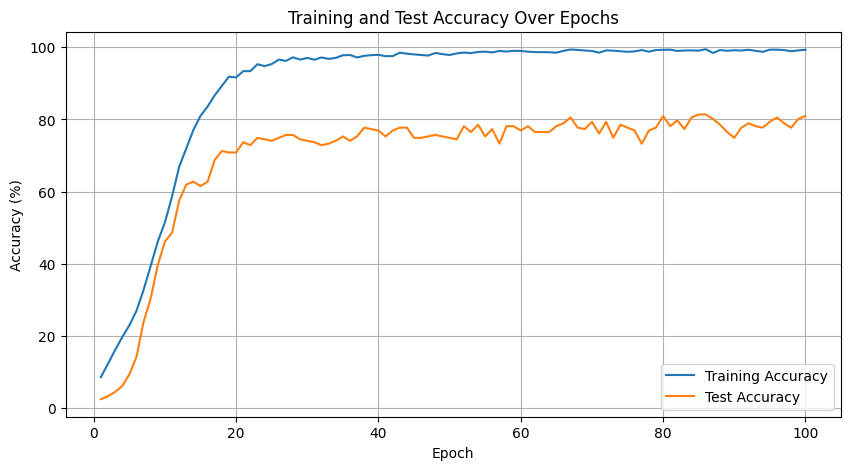

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()